# Прогнозирование температуры расплава для оптимизации энергоэффективности металлургического производства

## Общее описание и задачи

В этом проекте мы нацелены на оптимизацию энергоэффективности металлургического производства посредством прогнозирования температуры расплава стали. Наш заказчик — металлургический комбинат, который стремится снизить потребление электроэнергии на этапе обработки расплава. Ключевая идея состоит в том, чтобы обеспечить более точное управление технологическим процессом через своевременное и качественное предсказание конечной температуры расплава. Для этого используются данные, полученные с различных этапов технологического цикла, включая измерения дугового нагрева, объёмы и временные показатели подачи сыпучих и проволочных добавок, подачу газа, а также температурные измерения.

**Цель проекта**

Разработать модель, способную спрогнозировать финальную температуру расплава стали с наименьшей ошибкой, чтобы уменьшить потребление электроэнергии и оптимизировать производственный процесс на металлургическом комбинате.

**Основные задачи проекта**
1. Загрузка и предварительный анализ данных.
2. Объединение данных.
3. Исследовательский анализ объединенного датафрейма (EDA).
4. Построение пайплайна препроцессинга и обучения.
5. Интерпретация модели и анализ важности признаков.
6. Формирование выводов и рекомендаций.

In [1]:
!pip install scikit-learn==1.5.1 -q
!pip install matplotlib==3.5.1 -q
!pip install numpy==1.22.3 -q
!pip install pandas==1.2.4 -q
!pip install seaborn==0.11.2 -q
!pip install phik -q
!pip install shap -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from warnings import filterwarnings
import os
import matplotlib

filterwarnings("ignore")

from functools import reduce
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import shap

In [3]:
RANDOM_STATE = 70425
TEST_SIZE = 0.25

## Заргузка данных

In [4]:
def read_csv_file(local_path, url_path, **kwargs):
    if os.path.exists(local_path):
        return pd.read_csv(local_path, **kwargs)
    else:
        return pd.read_csv(url_path, **kwargs)


LOCAL_DATASETS_PATH = "datasets/"

FILES = [
    "data_arc_new.csv",
    "data_bulk_new.csv",
    "data_bulk_time_new.csv",
    "data_gas_new.csv",
    "data_temp_new.csv",
    "data_wire_new.csv",
    "data_wire_time_new.csv"
]

DATE_COLUMNS = {
    "data_arc_new.csv": ["Начало нагрева дугой", "Конец нагрева дугой"],
    "data_temp_new.csv": ["Время замера"],
    "data_bulk_time_new.csv": [f"Bulk {i}" for i in range(1, 16)],
    "data_wire_time_new.csv": [f"Wire {i}" for i in range(1, 10)],
}

datasets = {}
for file in FILES:
    parse_cols = DATE_COLUMNS.get(file)
    datasets[file.replace(".csv", "")] = read_csv_file(
        local_path=os.path.join(LOCAL_DATASETS_PATH, file),
        url_path=SERVER_DATASETS_PATH + file,
        parse_dates=parse_cols
    )

data_arc = datasets["data_arc_new"]
data_bulk = datasets["data_bulk_new"]
data_bulk_time = datasets["data_bulk_time_new"]
data_gas = datasets["data_gas_new"]
data_temp = datasets["data_temp_new"]
data_wire = datasets["data_wire_new"]
data_wire_time = datasets["data_wire_time_new"]

In [5]:
data_arc.info()
data_arc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [6]:
data_bulk.info()
data_bulk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [7]:
data_bulk_time.info()
data_bulk_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [8]:
data_gas.info()
data_gas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [9]:
data_temp.info()
data_temp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [10]:
data_wire.info()
data_wire.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data_wire_time.info()
data_wire_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Данные загружены. 

В каждом из датафреймов есть поле `key`, которое описывает номер партии.

Отдельно рассмотрим каждый:

`data_arc`: содержит почти 15 тысяч записей без пропусков. 

`data_bulk`: 3129 записей. Датафрейм с информацией, содержащей объем подаваемого сыпучего материала. Судя по всему — каждый столбец соответствует конкретному материалу. Где наличие записи означает то, сколько материала подавалось, а отсутствие, что этот материал в целом не был подан.

`data_bulk_time`: так же 3129 записей, что свидетельствует о том, что этот фрейм — продолжение предыдущего, только с временными метками.

`data_gas`: объем подаваемого газа. 3239 записей без пропусков.

`data_temp`: показатели ключевого признака в нашей работе, сразу же видно, что в столбце температуры есть около 3.5 тысяч пропусков. Скорее всего их нужно будет чем-то заполнить в дальнейшем.

 `data_wire`: проволочные материалы. Принцип аналогичен сыпучим материалам. 
 
 `data_wire_time`: временные метки подачи проволочных материалов.


Также изменим названия столбцов, чтобы они соответствовали кодстайлу.

In [12]:
data_arc = data_arc.rename(columns={
    "key": "key",
    "Начало нагрева дугой": "arc_heating_start",
    "Конец нагрева дугой": "arc_heating_end",
    "Активная мощность": "active_power",
    "Реактивная мощность": "reactive_power"
})


def rename_bulk(col):
    return col.lower().replace(" ", "_") if col != "key" else "key"


data_bulk = data_bulk.rename(columns=rename_bulk)
data_bulk_time = data_bulk_time.rename(columns=rename_bulk)

data_gas = data_gas.rename(columns={
    "key": "key",
    "Газ 1": "gas_1"
})

data_temp = data_temp.rename(columns={
    "key": "key",
    "Время замера": "measurement_time",
    "Температура": "temperature"
})


def rename_wire(col):
    return col.lower().replace(" ", "_") if col != "key" else "key"


data_wire = data_wire.rename(columns=rename_wire)
data_wire_time = data_wire_time.rename(columns=rename_wire)

## Исследовательский анализ и предобработка данных

Проведем предобработку данных и их первичный анализ. На следующем этапе объединим датафреймы в один и уже более детальнее рассмотрим признаки. 

In [13]:
frames = {
    "data_arc": data_arc,
    "data_bulk": data_bulk,
    "data_bulk_time": data_bulk_time,
    "data_gas": data_gas,
    "data_temp": data_temp,
    "data_wire": data_wire,
    "data_wire_time": data_wire_time
}

### Пропущенные и повторяющиеся значения

Рассмотрим датафреймы на предмет пропусков и дубликатов.

In [14]:
for name, df in frames.items():
    print(f"=== {name} ===")

    missing = df.isnull().sum()
    print("Количество пропусков в каждом столбце:")
    print(missing)

    dup_count = df.duplicated().sum()
    print("Количество полных дубликатов:", dup_count)

    print("\n")

=== data_arc ===
Количество пропусков в каждом столбце:
key                  0
arc_heating_start    0
arc_heating_end      0
active_power         0
reactive_power       0
dtype: int64
Количество полных дубликатов: 0


=== data_bulk ===
Количество пропусков в каждом столбце:
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
Количество полных дубликатов: 0


=== data_bulk_time ===
Количество пропусков в каждом столбце:
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
Количество полных дубликатов: 0


=== data_gas ===
Количество пропусков в каждом столбце:
k

Полных дубликатов в датафреймах нет. Пропусков как таковых тоже (мы не считаем не добавление материала как пропуск), за исключением фрейма с температурой. 

Изучим подробнее природу этих пропусков, чтобы решить что с ними делать.

In [15]:
missing_ratio = data_temp["temperature"].isnull().sum() / len(data_temp)
print(f"Соотношение числа пропусков от общего числа записей в датафрейме: {missing_ratio * 100:.2f}%")

Соотношение числа пропусков от общего числа записей в датафрейме: 18.94%


=== Пропуски по партиям ===


,measurements_total,measurements_valid,missing_count,missing_ratio
key,,,,
1,6,6,0,0.0
2,5,5,0,0.0
3,6,6,0,0.0
4,5,5,0,0.0
5,5,5,0,0.0
6,5,5,0,0.0
7,5,5,0,0.0
8,5,5,0,0.0
9,6,6,0,0.0


Всего партий: 3216
Партий, где температура не указана вообще: 0
Партий без пропусков температуры: 2477


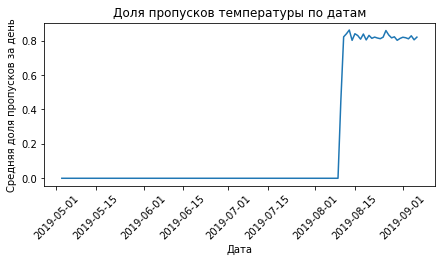

In [16]:
data_temp['missing_flag'] = data_temp['temperature'].isna().astype(int)

missing_stats_per_key = (
    data_temp
    .groupby('key')
    .agg(
        measurements_total=('temperature', 'size'),
        measurements_valid=('temperature', 'count'),
        missing_count=('missing_flag', 'sum'),
        missing_ratio=('missing_flag', 'mean')
    )
)

print("=== Пропуски по партиям ===")
display(missing_stats_per_key.head(10))

print("Всего партий:", missing_stats_per_key.shape[0])

full_missing = (missing_stats_per_key['measurements_valid'] == 0).sum()
print("Партий, где температура не указана вообще:", full_missing)

no_missing = (missing_stats_per_key['missing_count'] == 0).sum()
print("Партий без пропусков температуры:", no_missing)

data_temp['date'] = data_temp['measurement_time'].dt.date
missing_by_date = data_temp.groupby('date')['missing_flag'].mean()

plt.figure(figsize=(7, 3))
missing_by_date.plot()
plt.xlabel('Дата')
plt.ylabel('Средняя доля пропусков за день')
plt.title('Доля пропусков температуры по датам')
plt.xticks(rotation=45)
plt.show()

In [17]:
day_diffs = data_temp['date'].max() - data_temp['date'].min()
day_diffs.days

126

Измерения проводились 126 дней. Причем мы даже можем отследить, что до определенного моменента пропусков не было. Изучим этот кусок подробнее.

In [18]:
cutoff_date = pd.to_datetime("2019-08-10")

data_temp['after_cutoff'] = data_temp['measurement_time'] >= cutoff_date

before_missing = data_temp.loc[~data_temp['after_cutoff'], 'temperature'].isna().mean()
after_missing = data_temp.loc[data_temp['after_cutoff'], 'temperature'].isna().mean()

print(f"Доля пропусков до {cutoff_date.date()}: {before_missing:.2%}")
print(f"Доля пропусков после {cutoff_date.date()}: {after_missing:.2%}")

Доля пропусков до 2019-08-10: 0.00%
Доля пропусков после 2019-08-10: 80.86%


С уверенностью можно сказать, что в какой-то из дней первой половины августа произошел технический сбой, который повлиял на дальнейший сбор данных.

Заполним пропуски медианным значением для партии. Терять 20 процентов данных может быть слишком критично.

In [19]:
data_temp['temperature'] = data_temp.groupby('key')['temperature'].transform(
    lambda x: x.fillna(x.median())
)

data_temp['temperature'].isnull().sum()

0

Ещё раз убедимся, что после заполнения пропусков у нас не появились полные дубликаты.

In [20]:
full_duplicates_count = data_temp.duplicated().sum()
print("Число полных дубликатов в data_temp:", full_duplicates_count)

Число полных дубликатов в data_temp: 0


Посмотрим на графиках как выглядит теперь распределение.

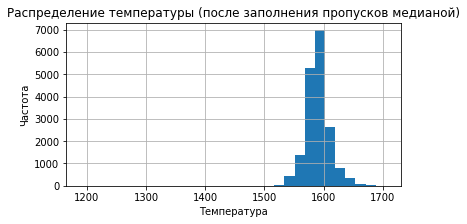

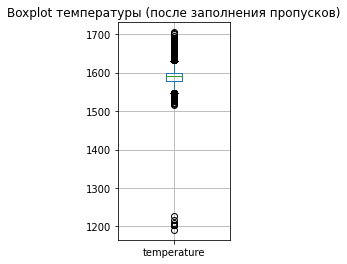

In [21]:
plt.figure(figsize=(6, 3))
data_temp['temperature'].hist(bins=30)
plt.title("Распределение температуры (после заполнения пропусков медианой)")
plt.xlabel("Температура")
plt.ylabel("Частота")
plt.show()

plt.figure(figsize=(2, 4))
data_temp.boxplot(column='temperature')
plt.title("Boxplot температуры (после заполнения пропусков)")
plt.show()

In [22]:
data_temp['temperature'].describe()

count    18092.000000
mean      1590.207440
std         22.255913
min       1191.000000
25%       1579.000000
50%       1590.000000
75%       1600.000000
max       1705.000000
Name: temperature, dtype: float64

Очень странно выглядят значения сильно ниже первого квантиля. Изучим их подробнее.

Трудно сказать без комментариев заказчика можно ли это считать валидной температурой при рассматриваемом технологическом процессе.

Замеры в партии 2561 выглядят точно как аномальные, температура идентичная с точностью до десятой градуса. 

Уберем эти замеры и сообщим об этом заказчику.

In [23]:
print(f"Значений сильно ниже 25% значений:{len(data_temp[data_temp['temperature'] < 1500])}")
data_temp[data_temp['temperature'] < 1500]

Значений сильно ниже 25% значений:10


,key,measurement_time,temperature,missing_flag,date,after_cutoff
4883,867,2019-06-06 08:03:39,1191.0,0,2019-06-06,False
6784,1214,2019-06-18 08:01:03,1208.0,0,2019-06-18,False
9050,1619,2019-07-03 02:34:41,1218.0,0,2019-07-03,False
11495,2052,2019-07-25 08:49:15,1227.0,0,2019-07-25,False
14283,2561,2019-08-12 18:49:29,1204.0,0,2019-08-12,True
14284,2561,2019-08-12 18:59:23,1204.0,1,2019-08-12,True
14285,2561,2019-08-12 19:06:26,1204.0,1,2019-08-12,True
14286,2561,2019-08-12 19:11:13,1204.0,1,2019-08-12,True
14287,2561,2019-08-12 19:17:08,1204.0,1,2019-08-12,True
14288,2561,2019-08-12 19:21:45,1204.0,1,2019-08-12,True


In [24]:
data_temp = data_temp[data_temp['temperature'] > 1500]
data_temp[data_temp['temperature'] < 1500]

,key,measurement_time,temperature,missing_flag,date,after_cutoff


Рассмотрим другие датафреймы.

=== data_arc: Статистика длительности дугового нагрева ===


count                        14876
mean     0 days 00:02:51.670946490
std      0 days 00:01:38.186802680
min                0 days 00:00:11
25%                0 days 00:01:47
50%                0 days 00:02:27
75%                0 days 00:03:34
max                0 days 00:15:07
Name: arc_duration, dtype: object

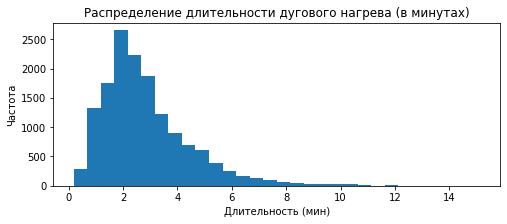

In [25]:
data_arc["arc_duration"] = data_arc["arc_heating_end"] - data_arc["arc_heating_start"]
print("=== data_arc: Статистика длительности дугового нагрева ===")

display(data_arc["arc_duration"].describe())

plt.figure(figsize=(8, 3))
plt.hist(data_arc["arc_duration"].dropna().dt.total_seconds() / 60, bins=30)
plt.title("Распределение длительности дугового нагрева (в минутах)")
plt.xlabel("Длительность (мин)")
plt.ylabel("Частота")
plt.show()

In [26]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [27]:
data_wire.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [28]:
data_gas.describe()

,key,gas_1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


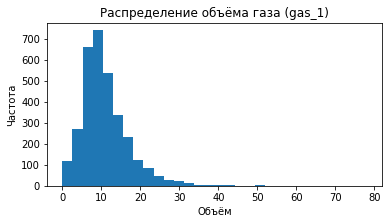

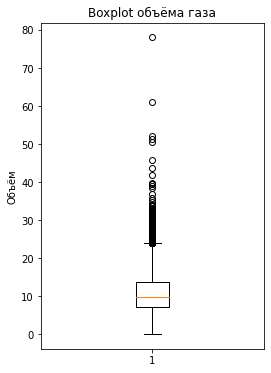

In [29]:
plt.figure(figsize=(6, 3))
plt.hist(data_gas["gas_1"].dropna(), bins=30)
plt.title("Распределение объёма газа (gas_1)")
plt.xlabel("Объём")
plt.ylabel("Частота")
plt.show()

plt.figure(figsize=(4, 6))
plt.boxplot(data_gas["gas_1"].dropna())
plt.title("Boxplot объёма газа")
plt.ylabel("Объём")
plt.show()

### Выводы

1. В данных нет полных дубликатов.
2. Явных пропусков в данных, кроме как датафрейма с температурой, также нет.
3. Температура не указана почти в `20%` случаев, что является значимой частью для нашего исследования.
4. Пропуски по температуре начались в один из дней первой половины августа. Это явный технический сбой, о котором следует оповестить заказчика.
5. Измерения проводились 126 дней.
6. Были удалены точечные выбросы по температуре и по количеству инертного газа.

## Объединение данных

Что возьмем в общий датафрейм?

`key` — идентификатор партии.

Признаки по дуговому нагреву (`arc_duration`, `active_power`, `reactive_power`).

Суммарный объёмы сыпучих материалов (`bulk_1` + ... + `bulk_15`).

Суммарные объёмы проволочных материалов (`wire_1` + ... + `wire_9`).

Первый замер температуры у партии.

Последний замер температуры у партии, что является целевое переменной (`final_temperature`).

Будем брать только те партии, которые есть во всех датафреймах.

In [30]:
data_arc = datasets["data_arc_new"]
data_bulk = datasets["data_bulk_new"]
data_temp = datasets["data_temp_new"]
data_wire = datasets["data_wire_new"]

data_arc = data_arc.rename(columns={
    "key": "key",
    "Начало нагрева дугой": "arc_heating_start",
    "Конец нагрева дугой": "arc_heating_end",
    "Активная мощность": "active_power",
    "Реактивная мощность": "reactive_power"
})

data_bulk = data_bulk.rename(columns=rename_bulk)
data_wire = data_wire.rename(columns=rename_wire)

data_temp = data_temp.rename(columns={
    "key": "key",
    "Время замера": "measurement_time",
    "Температура": "temperature"
})

In [31]:
data_arc['arc_duration'] = data_arc['arc_heating_end'] - data_arc['arc_heating_start']
data_arc['arc_duration'] = data_arc['arc_duration'].dt.total_seconds().astype(int)
agg_arc = data_arc.groupby('key').agg({
    'active_power': 'sum',
    'reactive_power': 'sum',
    'arc_duration': 'sum'
}).reset_index()

data_bulk['total_bulk'] = data_bulk[[c for c in data_bulk.columns if c.startswith('bulk_')]].sum(axis=1)
agg_bulk = data_bulk.groupby('key')['total_bulk'].sum().reset_index()

data_wire['total_wire'] = data_wire[[c for c in data_wire.columns if c.startswith('wire_')]].sum(axis=1)
agg_wire = data_wire.groupby('key')['total_wire'].sum().reset_index()

agg_temp = data_temp.groupby('key', as_index=False).agg(
    first_temperature=('temperature', 'first'),
    final_temperature=('temperature', 'last')
)

df_merged = agg_arc.merge(agg_bulk, on='key', how='inner')
df_merged = df_merged.merge(agg_wire, on='key', how='inner')
df_merged = df_merged.merge(agg_temp, on='key', how='inner')

temp_counts = data_temp.groupby('key')['temperature'].count()
valid_keys = temp_counts[temp_counts >= 2].index

df_merged = df_merged[df_merged['key'].isin(valid_keys)]

df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2331 non-null   int64  
 1   active_power       2331 non-null   float64
 2   reactive_power     2331 non-null   float64
 3   arc_duration       2331 non-null   int64  
 4   total_bulk         2331 non-null   float64
 5   total_wire         2331 non-null   float64
 6   first_temperature  2331 non-null   float64
 7   final_temperature  2331 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 163.9 KB


,key,active_power,reactive_power,arc_duration,total_bulk,total_wire,first_temperature,final_temperature
0,1,3.036730,2.142821,1098,553.0,60.059998,1571.0,1613.0
1,2,2.139408,1.453357,811,582.0,96.052315,1581.0,1602.0
2,3,4.063641,2.937457,655,544.0,91.160157,1596.0,1599.0
3,4,2.706489,2.056992,741,595.0,89.063515,1601.0,1625.0
4,5,2.252950,1.687991,869,584.0,98.352796,1576.0,1602.0


In [32]:
print("Число строк в объединённом датафрейме:", df_merged.shape[0])
print("Число уникальных партий (key):", df_merged['key'].nunique())
df_merged.head()

Число строк в объединённом датафрейме: 2331
Число уникальных партий (key): 2331


,key,active_power,reactive_power,arc_duration,total_bulk,total_wire,first_temperature,final_temperature
0,1,3.036730,2.142821,1098,553.0,60.059998,1571.0,1613.0
1,2,2.139408,1.453357,811,582.0,96.052315,1581.0,1602.0
2,3,4.063641,2.937457,655,544.0,91.160157,1596.0,1599.0
3,4,2.706489,2.056992,741,595.0,89.063515,1601.0,1625.0
4,5,2.252950,1.687991,869,584.0,98.352796,1576.0,1602.0


### Выводы

Мы получили общий датафрейм, который состоит из 8 столбцов:

1. Идентификатор партии.
2. Значение активной мощности.
3. Значение реактивной мощности.
4. Суммарная длительность нагрева дугой. 
5. Суммарное добавление сыпучих материалов.  
6. Суммарное добавление проволочных материалов. 
7. Первое измерение температуры.    
8. Итоговая температура.

## Исследовательский анализ и предобработка данных объединённого датафрейма

Выполним исследовательский анализ объединённого датафрейма, визуализируем распределения признаков.

In [33]:
df_merged.describe()

,key,active_power,reactive_power,arc_duration,total_bulk,total_wire,first_temperature,final_temperature
count,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000
mean,1250.952381,3.125572,1.993640,807.708280,609.652081,125.177124,1586.717289,1593.364650
std,715.087554,1.220722,14.863053,340.731247,287.486496,63.672650,28.279663,11.196375
min,1.000000,0.267676,-713.966032,57.000000,19.000000,1.918800,1191.000000,1541.000000
25%,628.500000,2.295914,1.669256,581.000000,440.000000,88.929355,1571.000000,1587.000000
50%,1254.000000,3.035365,2.225398,778.000000,609.000000,116.101440,1587.000000,1593.000000
75%,1867.500000,3.834305,2.829200,993.000000,795.000000,151.559715,1603.000000,1598.000000
max,2499.000000,12.375636,8.949049,4189.000000,3235.000000,568.777664,1660.000000,1653.000000


Изучим подозрительные значения в `reactive_power` < 0, хотя все остальные значения около 2.

Уберем это значение.

In [34]:
df_merged = df_merged[df_merged['reactive_power'] > 0]

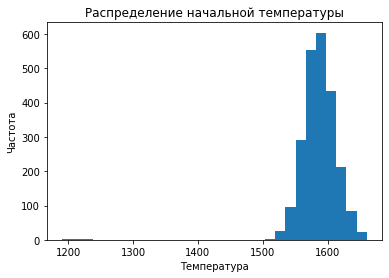

In [35]:
plt.hist(df_merged['first_temperature'], bins=30)
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.title('Распределение начальной температуры')
plt.show()

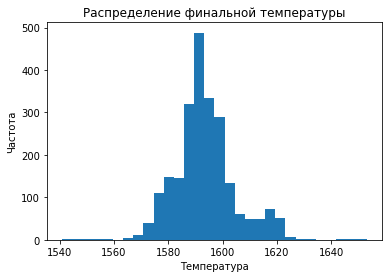

In [36]:
plt.hist(df_merged['final_temperature'], bins=30)
plt.xlabel('Температура')
plt.ylabel('Частота')
plt.title('Распределение финальной температуры')
plt.show()

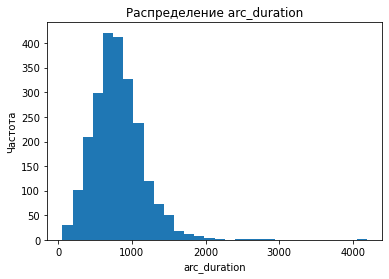

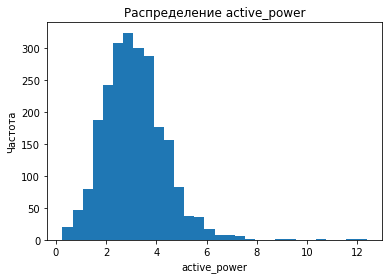

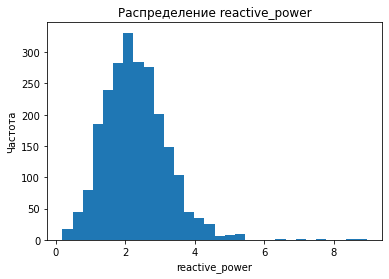

In [37]:
cols_arc = ['arc_duration', 'active_power', 'reactive_power']
for col in cols_arc:
    plt.hist(df_merged[col], bins=30)
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.title(f'Распределение {col}')
    plt.show()

,key,active_power,reactive_power,arc_duration,total_bulk,total_wire,first_temperature,final_temperature
key,1.00,0.11,0.09,0.03,0.13,0.22,0.19,0.22
active_power,0.11,1.00,0.98,0.78,0.65,0.20,0.21,0.48
reactive_power,0.09,0.98,1.00,0.78,0.63,0.16,0.16,0.36
arc_duration,0.03,0.78,0.78,1.00,0.73,0.06,0.31,0.32
total_bulk,0.13,0.65,0.63,0.73,1.00,0.09,0.08,0.18
total_wire,0.22,0.20,0.16,0.06,0.09,1.00,0.24,0.29
first_temperature,0.19,0.21,0.16,0.31,0.08,0.24,1.00,0.34
final_temperature,0.22,0.48,0.36,0.32,0.18,0.29,0.34,1.00


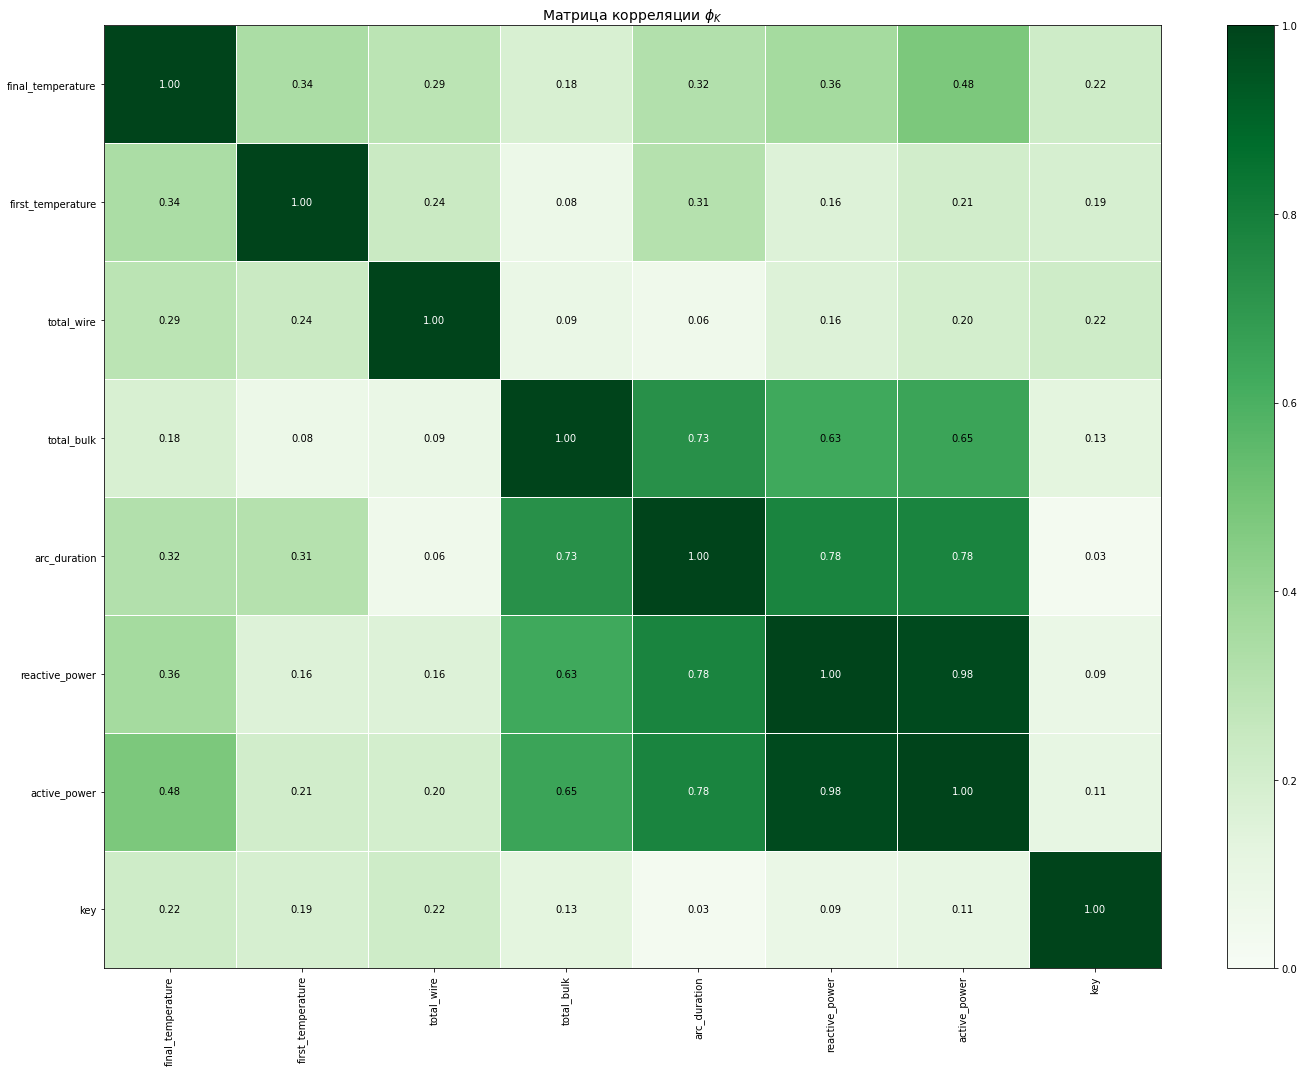

In [38]:
num_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()

phik_matrix = round(df_merged.phik_matrix(interval_cols=num_cols), 2)

display(phik_matrix)

plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции $\phi_K$',
    fontsize_factor=1,
    figsize=(20, 15)
)

Уберем один из сильно коррелирующих признаков дугового нагрева. Из пары `active_power` и `reactive_power` оставляем только `active_power`.

Также удалим номер партии. Он нам не понадобится при обучении.

In [39]:
df_merged = df_merged.drop(columns=['key', 'reactive_power'])
df_merged

,active_power,arc_duration,total_bulk,total_wire,first_temperature,final_temperature
0,3.036730,1098,553.0,60.059998,1571.0,1613.0
1,2.139408,811,582.0,96.052315,1581.0,1602.0
2,4.063641,655,544.0,91.160157,1596.0,1599.0
3,2.706489,741,595.0,89.063515,1601.0,1625.0
4,2.252950,869,584.0,98.352796,1576.0,1602.0
...,...,...,...,...,...,...
2326,3.168133,723,719.0,89.150879,1570.0,1591.0
2327,4.174918,940,796.0,114.179527,1554.0,1591.0
2328,3.605239,569,665.0,103.134723,1571.0,1589.0
2329,3.202310,750,733.0,118.110717,1591.0,1594.0


,active_power,arc_duration,total_bulk,total_wire,first_temperature,final_temperature
active_power,1.00,0.78,0.65,0.20,0.21,0.48
arc_duration,0.78,1.00,0.73,0.06,0.31,0.32
total_bulk,0.65,0.73,1.00,0.09,0.08,0.18
total_wire,0.20,0.06,0.09,1.00,0.24,0.29
first_temperature,0.21,0.31,0.08,0.24,1.00,0.34
final_temperature,0.48,0.32,0.18,0.29,0.34,1.00


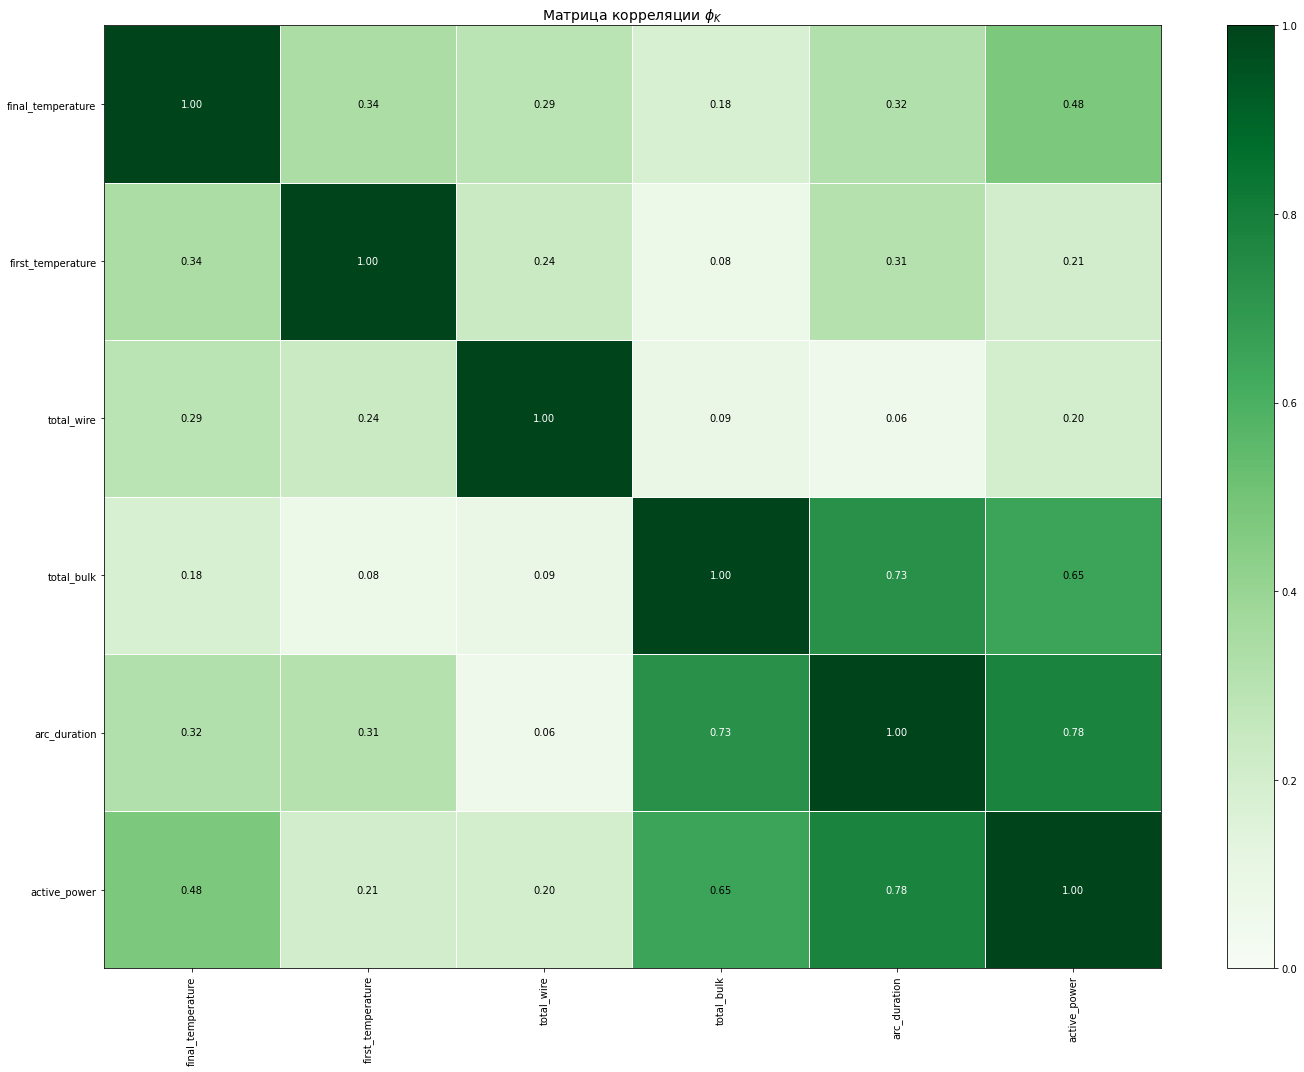

In [40]:
num_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()

phik_matrix = round(df_merged.phik_matrix(interval_cols=num_cols), 2)

display(phik_matrix)

plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Матрица корреляции $\phi_K$',
    fontsize_factor=1,
    figsize=(20, 15)
)

По шкале Чеддока (которая примерно интерпретирует коэффициенты корреляции так: 0–0.10 – очень слабая связь, 0.10–0.30 – низкая, 0.30–0.50 – средняя, 0.50–0.70 – сильная, 0.70–0.90 – очень сильная, 0.90–1.00 – практически полная).

### Выводы

1. Дублирующих значений в объединенных данных нет.
2. Для обучения мы оставим только данные без выбросов, которые попадают в 1.5 межквартильных размаха.
3. Была проведена базовая работа с признаками (удаление и объединение).
4. По шкале Чеддока результаты показывают, что длительность дугового нагрева является доминирующим фактором для определения финальной температуры.

## Подготовка данных

Предварительную подготовку данных проведем ниже в пайплайне. Рассмотрим получившийся датафрейм и разделим его на выборки.

In [41]:
features = ['active_power', 'arc_duration', 'total_bulk', 'total_wire', 'first_temperature']
target = 'final_temperature'

df_model = df_merged[features + [target]].copy()

X = df_model.drop(columns=[target])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("Размер тренировочной выборки:", X_train.shape[0])
print("Размер тестовой выборки:", X_test.shape[0])

Размер тренировочной выборки: 1747
Размер тестовой выборки: 583


In [42]:
def remove_outliers_iqr(data, cols, iqr_mult=1.5):
    mask = pd.Series(True, index=data.index)
    for c in cols:
        q1 = data[c].quantile(0.25)
        q3 = data[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_mult * iqr
        upper = q3 + iqr_mult * iqr
        mask &= (data[c] >= lower) & (data[c] <= upper)
    return mask

train_data = X_train.copy()
train_data[target] = y_train

cols_for_outliers = ['active_power', 'arc_duration', 'total_bulk', 'total_wire', 'first_temperature', 'final_temperature']
mask_train = remove_outliers_iqr(train_data, cols_for_outliers, iqr_mult=2.7)
train_data_clean = train_data[mask_train]

X_train_clean = train_data_clean.drop(columns=[target])
y_train_clean = train_data_clean[target]

print("Размер исходной тренировочной выборки ДО удаления выбросов:", X_train.shape[0])
print("Размер исходной тренировочной выборки ПОСЛЕ удаления выбросов:", X_train_clean.shape[0])

Размер исходной тренировочной выборки ДО удаления выбросов: 1747
Размер исходной тренировочной выборки ПОСЛЕ удаления выбросов: 1700


## Обучение моделей машинного обучения

В качестве моделей машинного обучения возьмем: ridge-регрессию, градиентный бустинг (LightGBM), дерево решений и случайный лес.

Будем использовать в качестве лосса среднеквадратичную ошибку (MSE).

In [43]:
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid_ridge = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 300.0, 1000.0]
}

In [44]:
pipeline_lgb = Pipeline([
    ('scaler', StandardScaler()),
    ('lgb', LGBMRegressor(random_state=RANDOM_STATE))
])

param_grid_lgb = {
    'lgb__n_estimators': [50, 100, 200],
    'lgb__max_depth': [3, 5, 7],
    'lgb__learning_rate': [0.01, 0.1, 0.15, 0.2],
    'lgb__num_leaves': [31, 50, 100],
    'lgb__min_child_samples': [5, 10, 20],
}

In [45]:
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid_dt = {
    'dt__max_depth': [None, 3, 5, 7, 10],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 5, 10]
}

In [46]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE))
])

param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 7, 10],
    'rf__min_samples_split': [2, 3, 5],
    'rf__min_samples_leaf': [1, 2, 5],
    'rf__max_features': ['auto', 'sqrt', 0.8]
}

In [47]:
models = {
    'Ridge': (pipeline_ridge, param_grid_ridge),
    'LightGBM': (pipeline_lgb, param_grid_lgb),
    'DecisionTree': (pipeline_dt, param_grid_dt),
    'RandomForest': (pipeline_rf, param_grid_rf)
}

In [48]:
best_models = {}

for name, (pipeline, param_grid) in models.items():
    print(f"Запуск GridSearchCV для модели {name}...")
    grid = GridSearchCV(pipeline, param_grid, cv=5,
                        scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
    grid.fit(X_train_clean, y_train_clean)
    best_models[name] = grid
    print(f"{name} – лучшие параметры: {grid.best_params_}")
    print(f"{name} – лучшая CV MAE: {-grid.best_score_:.2f}\n")

Запуск GridSearchCV для модели Ridge...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................................ridge__alpha=0.001; total time=   0.0s
[CV] END .................................ridge__alpha=0.001; total time=   0.0s
[CV] END .................................ridge__alpha=0.001; total time=   0.0s
[CV] END .................................ridge__alpha=0.001; total time=   0.0s
[CV] END .................................ridge__alpha=0.001; total time=   0.0s
[CV] END ..................................ridge__alpha=0.01; total time=   0.0s
[CV] END ..................................ridge__alpha=0.01; total time=   0.0s
[CV] END ..................................ridge__alpha=0.01; total time=   0.0s
[CV] END ..................................ridge__alpha=0.01; total time=   0.0s
[CV] END ..................................ridge__alpha=0.01; total time=   0.0s
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END 

In [49]:
best_model_name, best_model_grid = max(best_models.items(), key=lambda item: item[1].best_score_)

print("Лучшая модель:", best_model_name)
print("Лучшие параметры:", best_model_grid.best_params_)
print("CV MAE: {:.2f}".format(-best_model_grid.best_score_))

Лучшая модель: LightGBM
Лучшие параметры: {'lgb__learning_rate': 0.15, 'lgb__max_depth': 3, 'lgb__min_child_samples': 20, 'lgb__n_estimators': 50, 'lgb__num_leaves': 31}
CV MAE: 6.79


В итоге лучшей моделью на кросс-валидации стал градиентный бустинг c показателем MAE `6.79`.

In [50]:
y_pred = best_model_grid.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("MAE на тестовом наборе: {:.2f}".format(mae_test))
print("R2 на тестовом наборе: {:.2f}".format(r2_test))

MAE на тестовом наборе: 6.49
R2 на тестовом наборе: 0.30


На тесте модель также показывает хороший результат — `6.49`.

$R^2 = 0.30$ говорит о том, что `30%` изменений в целевой переменной можно объяснить по данным, использованным в модели. Остальные `70%` объясняются ошибками модели, случайными колебаниями или характеристиками, которые не были учтены.

Проверим модель на адекватность, проверим, не зря ли мы вообще проделали столько работы.

In [51]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

dummy_mae = mean_absolute_error(y_test, y_pred_dummy)
print("Dummy-модель – тестовое MAE:", dummy_mae)

Dummy-модель – тестовое MAE: 7.791848019785935


Рассмотрим важность признаков нашей модели.

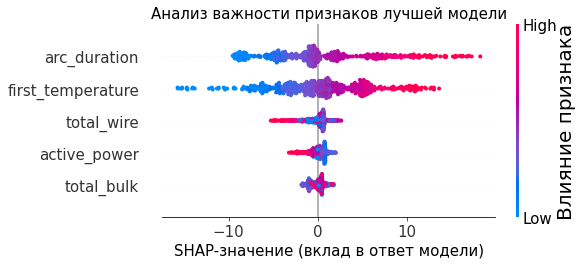

In [52]:
best_model = best_model_grid.best_estimator_

model_step = best_model.named_steps['lgb']
preprocessor = best_model.named_steps['scaler']

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()

explainer = shap.Explainer(model_step, X_train_transformed)
shap_values = explainer(X_test_transformed, check_additivity=False)

shap_values_array = shap_values.values

if shap_values_array.ndim == 1:
    shap_values_array = shap_values_array.reshape(-1, 1)

shap.summary_plot(shap_values_array, X_test_transformed, feature_names=feature_names, show=False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=15)
ax.set_xlabel('SHAP-значение (вклад в ответ модели)', fontsize=15)
ax.set_title('Анализ важности признаков лучшей модели', fontsize=15)

if len(fig.axes) > 1:
    cb_ax = fig.axes[1]
    cb_ax.tick_params(labelsize=15)
    cb_ax.set_ylabel('Влияние признака', fontsize=20)

plt.show()

В большей степени на предсказания модели оказывают влияние начальная температура и длительность нагрева дугой.

В меньшей — добавочные материалы и значение активной мощности.

### Выводы

1. Мы обучили четыре разных модели машинного обучения: линейную регрессию, градиентный бустинг (LightGBM), дерево решений и случайный лес.
2. Для каждой из модели были подобраны несколько гиперпараметров.
3. Лучшей моделью на кросс-валидации стал градиентный бустинг с показателем $\text{MAE} = 6.79$.
4. Показатель качества на тестовых данных $\text{MAE} = 6.49, R^2 = 0.30$.
5. Модель адекватна.
6. В большей степени на предсказания модели оказывают влияние начальная температура и длительность нагрева дугой.
7. В меньшей — добавочные материалы и значение активной мощности.

## Общие выводы и отчет

Работа включала комплексную загрузку, чистку, агрегацию разнородных данных (температура, дуговой нагрев, добавление материалов и т.д.), исследовательский анализ и построение пайплайнов машинного обучения с оптимизацией гиперпараметров для точного прогноза финальной температуры расплава.

**Выполненные этапы**

1. Загрузка и предобработка данных. Данные с различных этапов технологического цикла (дуговой нагрев, сыпучие и проволочные материалы, температурные замеры) успешно загружены. Проведён предварительный анализ – выявлены пропуски (например, 18,94% пропусков температуры после технического сбоя) и выбросы (аномальные значения температуры, а также выбросы объёма газа).
2. Объединение данных. Данные агрегированы по ключевому идентификатору (партии) с вычислением таких признаков, как длительность дугового нагрева, суммарные объёмы материалов и температурные замеры (первый и итоговый).
3. EDA и анализ корреляций. Построена корреляционная матрица (с использованием φₖ-метрики) для понимания взаимосвязей между признаками.
4. Построение пайплайнов и обучение моделей. Реализованы несколько моделей (Ridge-регрессия, LightGBM, DecisionTree, RandomForest) с применением GridSearchCV и использованием стандартной предобработки (стандартизация признаков).
5. Интерпретация и выводы. На основе полученных результатов выделен ключевой признак (длительность дугового нагрева) и проведён анализ важности признаков.

**Возникшние трудности**
1. Обнаружение значительного процента пропусков температуры после технического сбоя в августе – решено заполнением медианным значением по каждой партии, чтобы не терять данные.
2. Полная интеграция с обратной связью от заказчика по поводу аномалий данных (например, аномальные температуры в партии 2561) требует дополнительного обсуждения, поскольку требуется уточнение технологических деталей производственного процесса.

**Список признаков для обучения и их предобработка**

`active_power`. Измеренная активная мощность дугового нагрева. Признак подвергся стандартизации (StandardScaler).

`arc_duration`. Длительность дугового нагрева, вычисленная как разница между началом и концом процесса, преобразована в секунды и агрегирована по партии.

`total_bulk`. Суммарный объём сыпучих материалов, полученный путём суммирования значений по 15-ти столбцам для каждой партии. Пропуски интерпретировались как отсутствие подачи материала.

`total_wire`. Суммарный объём проволочных материалов, агрегированный аналогичным образом.

`first_temperature`. Первое измерение температуры в партии, выбранное после заполнения пропусков (медианой по партии).

`final_temperature` (целевой признак). Последнее измерение температуры, являющееся переменной, которую необходимо прогнозировать.

**Предобработка включает**
1. Заполнение пропусков в температуре медианными значениями по партиям.
2. Исключение аномальных значений (значения, значительно отклоняющиеся по межквартильному размаху).
3. Стандартизацию признаков для построения моделей.
  
**Гиперпараметры лучшей модели**

Лучшая модель: LightGBM

Лучшие параметры: {'lgb__learning_rate': 0.15, 'lgb__max_depth': 3, 'lgb__min_child_samples': 20, 'lgb__n_estimators': 50, 'lgb__num_leaves': 31}

random_state: 70425

CV MAE: 6.79

TEST MAE: 6.49

TEST R2: 0.30


**Рекомендации для улучшения модели и решения задачи**

1. Провести детальный анализ технологических особенностей производства для уточнения допускаемых диапазонов признаков (например, температурные аномалии, объемы газа).
2. Расширить набор признаков, включая временные компоненты (день недели, сезонные факторы) и признаки взаимодействия между переменными.
3. Рассмотреть использование ансамблевых методов (например, stacking) для повышения устойчивости прогноза.
4. Использовать более продвинутые методы гиперпараметрической оптимизации (например, Bayesian Optimization) для тонкой настройки моделей.
5. Дополнительно исследовать влияние удалённых выбросов и оценить возможность их коррекции вместо полного удаления, чтобы сохранить информацию о редких, но потенциально значимых событиях.
